In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import cProfile
import pstats

# Data loading and preprocessing
cp_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\archive(6)\CP_Data.csv")  # Correct path if needed
wisconsin_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\archive(6)\wisconsin.csv")  # Correct path if needed

common_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave points_mean",
    "symmetry_mean", "fractal_dimension_mean"
]

cp_data = cp_data[common_features + ["diagnosis"]].copy()
wisconsin_data = wisconsin_data[common_features + ["diagnosis"]].copy()

merged_data = pd.concat([cp_data, wisconsin_data], ignore_index=True)
merged_data["diagnosis"] = merged_data["diagnosis"].map({"M": 1, "B": 0})
merged_data = merged_data.dropna()

X = merged_data[common_features].values
y = merged_data["diagnosis"].values

# Feature scaling (before train/test split)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

num_qubits = len(common_features)

# Quantum setup (lightning.qubit if possible)
try:
    dev = qml.device("lightning.qubit", wires=num_qubits)
    print("Using lightning.qubit for faster simulations.")
except (ImportError, qml.DeviceError):
    dev = qml.device("default.qubit", wires=num_qubits)
    print("lightning.qubit not found. Using default.qubit (simulations will be slower).")

# Optimized quantum circuit (fewer layers to start)
def quantum_circuit(params, x):
    for i in range(num_qubits):
        qml.Hadamard(wires=i)  # Start with Hadamard
        qml.RY(x[i], wires=i)    # RY is often more efficient
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits)) # Start with 2 layers (or even 1)

@qml.qnode(dev)
def quantum_node(params, x):
    quantum_circuit(params, x)
    return qml.expval(qml.PauliZ(0))

num_layers = 2  # Start with fewer layers
params = pnp.random.uniform(0, 2 * pnp.pi, size=(num_layers, num_qubits, 3), requires_grad=True)  # Use pnp.pi

def hybrid_model(params, X):
    return pnp.array([quantum_node(params, x) for x in X])

def cost(params, X, y):
    predictions = hybrid_model(params, X)
    loss = pnp.mean((predictions - y) ** 2)
    return loss

# Optimization (Adam optimizer, tuned learning rate)
opt = qml.AdamOptimizer(stepsize=0.01)  # Tune this learning rate!
steps = 20  # More steps

# Profiling (comment out if you want to stop with KeyboardInterrupt)
pr = cProfile.Profile()
pr.enable()


for step in range(steps):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)
    if step % 10 == 0:
        c = cost(params, X_train, y_train)
        print(f"Step {step}: Cost = {c}")
        if c < 0.1:  # Early stopping (adjust threshold as needed)
            print("Cost reached threshold. Stopping early.")
            break 

pr.disable()
stats = pstats.Stats(pr)
stats.sort_stats('time').print_stats(20) # Print top 20 time-consuming functions

# Predictions and evaluation (same as before)
quantum_predictions = hybrid_model(params, X_test)
quantum_predictions = [1 if p > 0 else 0 for p in quantum_predictions]

svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

quantum_accuracy = accuracy_score(y_test, quantum_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print(f"Quantum Model Accuracy: {quantum_accuracy}")
print(f"Classical SVM Accuracy: {svm_accuracy}")






lightning.qubit not found. Using default.qubit (simulations will be slower).
Step 0: Cost = 0.3832309212484578
Step 10: Cost = 0.3801284403728642
         3099241491 function calls (3001888640 primitive calls) in 3762.488 seconds

   Ordered by: internal time
   List reduced from 719 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1681680 1272.125    0.001 1274.523    0.001 d:\ANACONDA\Lib\site-packages\pennylane\queuing.py:306(append)
109558816/51032958  182.891    0.000 1468.200    0.000 d:\ANACONDA\Lib\site-packages\autograd\tracer.py:35(f_wrapped)
 43736602  163.030    0.000  352.024    0.000 d:\ANACONDA\Lib\site-packages\autograd\tracer.py:58(f_wrapped)
 24176910  162.054    0.000  608.653    0.000 d:\ANACONDA\Lib\site-packages\pennylane\numpy\tensor.py:134(__array_ufunc__)
109558816  147.664    0.000  185.586    0.000 d:\ANACONDA\Lib\site-packages\autograd\tracer.py:65(find_top_boxed_args)
 16962460   91.349    0.000  362.1

In [6]:
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

# Load datasetscsv
cp_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\CP_Data.csv")
wisconsin_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\wisconsin.csv")

# Features to use
common_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave points_mean",
    "symmetry_mean", "fractal_dimension_mean"
]

# Merge datasets
cp_data = cp_data[common_features + ["diagnosis"]]
wisconsin_data = wisconsin_data[common_features + ["diagnosis"]]
merged_data = pd.concat([cp_data, wisconsin_data], ignore_index=True)

# Encode diagnosis (M = 1, B = 0)
merged_data["diagnosis"] = merged_data["diagnosis"].map({"M": 1, "B": 0})
merged_data.dropna(inplace=True)

# Prepare input and output
X = merged_data[common_features].values
y = merged_data["diagnosis"].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

num_qubits = len(common_features)

# Quantum device (lightning.qubit if available)
try:
    dev = qml.device("lightning.qubit", wires=num_qubits)
    print("Using lightning.qubit for faster simulations.")
except:
    dev = qml.device("default.qubit", wires=num_qubits)
    print("Using default.qubit.")

# Quantum circuit with trainable parameters
def quantum_circuit(params, x):
    """Parameterized quantum circuit"""
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)  # Encoding classical data
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits))

@qml.qnode(dev)
def quantum_node(params, x):
    quantum_circuit(params, x)
    return qml.expval(qml.PauliZ(0))  # Expectation value as output

# Sigmoid activation function for probability output
def sigmoid(x):
    return 1 / (1 + pnp.exp(-x))

def hybrid_model(params, X):
    """Quantum-classical hybrid model"""
    raw_outputs = pnp.array([quantum_node(params, x) for x in X])
    return sigmoid(raw_outputs)  # Convert to probability (0 to 1)

# Loss function: Binary cross-entropy
def cost(params, X, y):
    predictions = hybrid_model(params, X)
    return -pnp.mean(y * pnp.log(predictions) + (1 - y) * pnp.log(1 - predictions))

# Initialize trainable parameters
num_layers = 10  # More layers for better learning
params = pnp.random.uniform(0, 2 * pnp.pi, size=(num_layers, num_qubits, 3), requires_grad=True)

# Train with Adam optimizer
opt = qml.AdamOptimizer(stepsize=0.01)
steps = 140  # More steps for better training

for step in range(steps):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)
    if step % 10 == 0:
        c = cost(params, X_train, y_train)
        print(f"Step {step}: Cost = {c}")

# Quantum model predictions
quantum_predictions = hybrid_model(params, X_test)
quantum_predictions = [1 if p > 0.5 else 0 for p in quantum_predictions]  # Convert probabilities to labels

# Classical SVM model for comparison
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

# Accuracy comparison
quantum_accuracy = accuracy_score(y_test, quantum_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print(f"Quantum Model Accuracy: {quantum_accuracy:.4f}")
print(f"Classical SVM Accuracy: {svm_accuracy:.4f}")

quantum_predictions = hybrid_model(params, X_test)
print("Raw Quantum Predictions:", quantum_predictions)  
quantum_predictions = [1 if p > 0.5 else 0 for p in quantum_predictions]
print("Thresholded Predictions:", quantum_predictions)

print("Sample Test Data:", X_test[:5])



Using default.qubit.


KeyboardInterrupt: 

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
cp_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\CP_Data.csv")
wisconsin_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\wisconsin.csv")

# Features to use
common_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave points_mean",
    "symmetry_mean", "fractal_dimension_mean"
]

# Merge datasets
cp_data = cp_data[common_features + ["diagnosis"]]
wisconsin_data = wisconsin_data[common_features + ["diagnosis"]]
merged_data = pd.concat([cp_data, wisconsin_data], ignore_index=True)

# Encode diagnosis (M = 1, B = 0)
merged_data["diagnosis"] = merged_data["diagnosis"].map({"M": 1, "B": 0})
merged_data.dropna(inplace=True)

# Prepare input and output
X = merged_data[common_features].values
y = merged_data["diagnosis"].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

num_qubits = len(common_features)

# Quantum device (lightning.qubit if available)
try:
    dev = qml.device("lightning.qubit", wires=num_qubits)
    print("Using lightning.qubit for faster simulations.")
except Exception:
    dev = qml.device("default.qubit", wires=num_qubits)
    print("Using default.qubit.")

# Quantum circuit with trainable parameters
@qml.qnode(dev, interface="autograd")
def quantum_node(params, x):
    """Parameterized quantum circuit"""
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)  # Encoding classical data
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits))
    return qml.expval(qml.PauliZ(0))  # Expectation value as output

# Vectorized quantum function for better performance
quantum_batch = qml.batch_params(quantum_node)

# Sigmoid activation function for probability output
def sigmoid(x):
    return 1 / (1 + pnp.exp(-x))

def hybrid_model(params, X):
    """Quantum-classical hybrid model"""
    raw_outputs = quantum_batch(params, X)  # Vectorized execution
    return sigmoid(pnp.array(raw_outputs))  # Convert to probability (0 to 1)

# Loss function: Binary cross-entropy
def cost(params, X, y):
    predictions = hybrid_model(params, X)
    return -pnp.mean(y * pnp.log(predictions) + (1 - y) * pnp.log(1 - predictions))

# Initialize trainable parameters
num_layers = 5  # Reduce layers for efficiency
params = pnp.random.uniform(0, 2 * pnp.pi, size=(num_layers, num_qubits, 3), requires_grad=True)

# Train with Adam optimizer
opt = qml.AdamOptimizer(stepsize=0.01)
steps = 100  # Reduced steps for efficiency

for step in range(steps):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)
    if step % 10 == 0:
        c = cost(params, X_train, y_train)
        print(f"Step {step}: Cost = {c:.4f}")

# Quantum model predictions
quantum_predictions = hybrid_model(params, X_test)
quantum_predictions = [1 if p > 0.5 else 0 for p in quantum_predictions]  # Convert probabilities to labels

# Classical SVM model for comparison
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

# Accuracy comparison
quantum_accuracy = accuracy_score(y_test, quantum_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print(f"Quantum Model Accuracy: {quantum_accuracy:.4f}")
print(f"Classical SVM Accuracy: {svm_accuracy:.4f}")

# Print final predictions
print("Raw Quantum Predictions:", hybrid_model(params, X_test)[:10])  
print("Thresholded Predictions:", quantum_predictions[:10])

print("Sample Test Data:", X_test[:5])


Using default.qubit.


IndexError: tuple index out of range

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cp_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\CP_Data.csv")
wisconsin_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\wisconsin.csv")

# Features to use
common_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave points_mean",
    "symmetry_mean", "fractal_dimension_mean"
]

# Merge datasets
cp_data = cp_data[common_features + ["diagnosis"]]
wisconsin_data = wisconsin_data[common_features + ["diagnosis"]]
merged_data = pd.concat([cp_data, wisconsin_data], ignore_index=True)

# Encode diagnosis (M = 1, B = 0)
merged_data["diagnosis"] = merged_data["diagnosis"].map({"M": 1, "B": 0})
merged_data.dropna(inplace=True)

# Prepare input and output
X = merged_data[common_features].values
y = merged_data["diagnosis"].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

num_qubits = len(common_features)

# Quantum device (lightning.qubit if available)
try:
    dev = qml.device("lightning.qubit", wires=num_qubits)
    print("Using lightning.qubit for faster simulations.")
except:
    dev = qml.device("default.qubit", wires=num_qubits)
    print("Using default.qubit.")

# Quantum circuit with trainable parameters
def quantum_circuit(params, x):
    """Parameterized quantum circuit"""
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)  # Encoding classical data
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits))

@qml.qnode(dev)
def quantum_node(params, x):
    quantum_circuit(params, x)
    return qml.expval(qml.PauliZ(0))  # Expectation value as output

# Sigmoid activation function for probability output
def sigmoid(x):
    return 1 / (1 + pnp.exp(-x))

def hybrid_model(params, X):
    """Quantum-classical hybrid model"""
    raw_outputs = pnp.array([quantum_node(params, x) for x in X])
    return sigmoid(raw_outputs)  # Convert to probability (0 to 1)

# Loss function: Binary cross-entropy
def cost(params, X, y):
    predictions = hybrid_model(params, X)
    return -pnp.mean(y * pnp.log(predictions) + (1 - y) * pnp.log(1 - predictions))

# Initialize trainable parameters
num_layers = 10  # More layers for better learning
params = pnp.random.uniform(0, 2 * pnp.pi, size=(num_layers, num_qubits, 3), requires_grad=True)

# Train with Adam optimizer
opt = qml.AdamOptimizer(stepsize=0.01)
steps = 150  # More steps for better training

for step in range(steps):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)
    if step % 10 == 0:
        c = cost(params, X_train, y_train)
        print(f"Step {step}: Cost = {c}")

# Quantum model predictions
quantum_predictions = hybrid_model(params, X_test)
quantum_predictions = [1 if p > 0.5 else 0 for p in quantum_predictions]  # Convert probabilities to labels

# Classical SVM model for comparison
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

# Accuracy comparison
quantum_accuracy = accuracy_score(y_test, quantum_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print(f"Quantum Model Accuracy: {quantum_accuracy:.4f}")
print(f"Classical SVM Accuracy: {svm_accuracy:.4f}")

quantum_predictions = hybrid_model(params, X_test)
print("Raw Quantum Predictions:", quantum_predictions)  
quantum_predictions = [1 if p > 0.5 else 0 for p in quantum_predictions]
print("Thresholded Predictions:", quantum_predictions)

print("sample test Data:",X_test[:5])

cp_data = cp_data[common_features + ["diagnosis"]]
wisconsin_data = wisconsin_data[common_features + ["diagnosis"]]
merged_data = pd.concat([cp_data, wisconsin_data], ignore_index=True)

# Encode diagnosis (M = 1, B = 0)
merged_data["diagnosis"] = merged_data["diagnosis"].map({"M": 1, "B": 0})
merged_data.dropna(inplace=True)

### Class Distribution (Malignant vs Benign) ###
plt.figure(figsize=(6, 4))
sns.countplot(x=merged_data["diagnosis"], palette=["green", "red"])
plt.xticks(ticks=[0, 1], labels=["Benign", "Malignant"])
plt.title("Class Distribution of Breast Cancer")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

### Histograms of Features ###
merged_data[common_features].hist(figsize=(12, 10), bins=30, color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

### Correlation Heatmap ###
plt.figure(figsize=(10, 8))
corr_matrix = merged_data[common_features + ["diagnosis"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Box Plots for Feature Comparison ###
plt.figure(figsize=(12, 8))
for i, feature in enumerate(common_features[:6]):  # Select first 6 for readability
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x="diagnosis", y=feature, data=merged_data, palette=["green", "red"])
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

### Pairplot of Key Features ###
sns.pairplot(merged_data, hue="diagnosis", vars=common_features[:5], palette=["green", "red"])
plt.suptitle("Pairplot of Key Features", fontsize=14)
plt.show()


Using default.qubit.


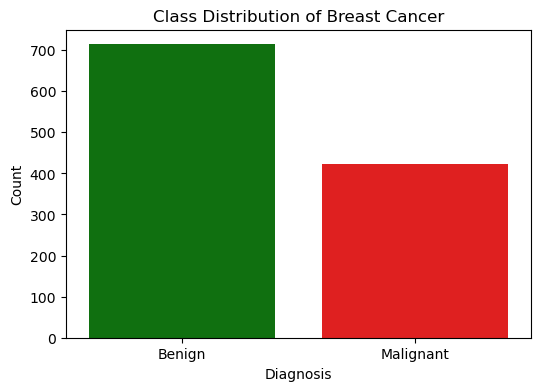

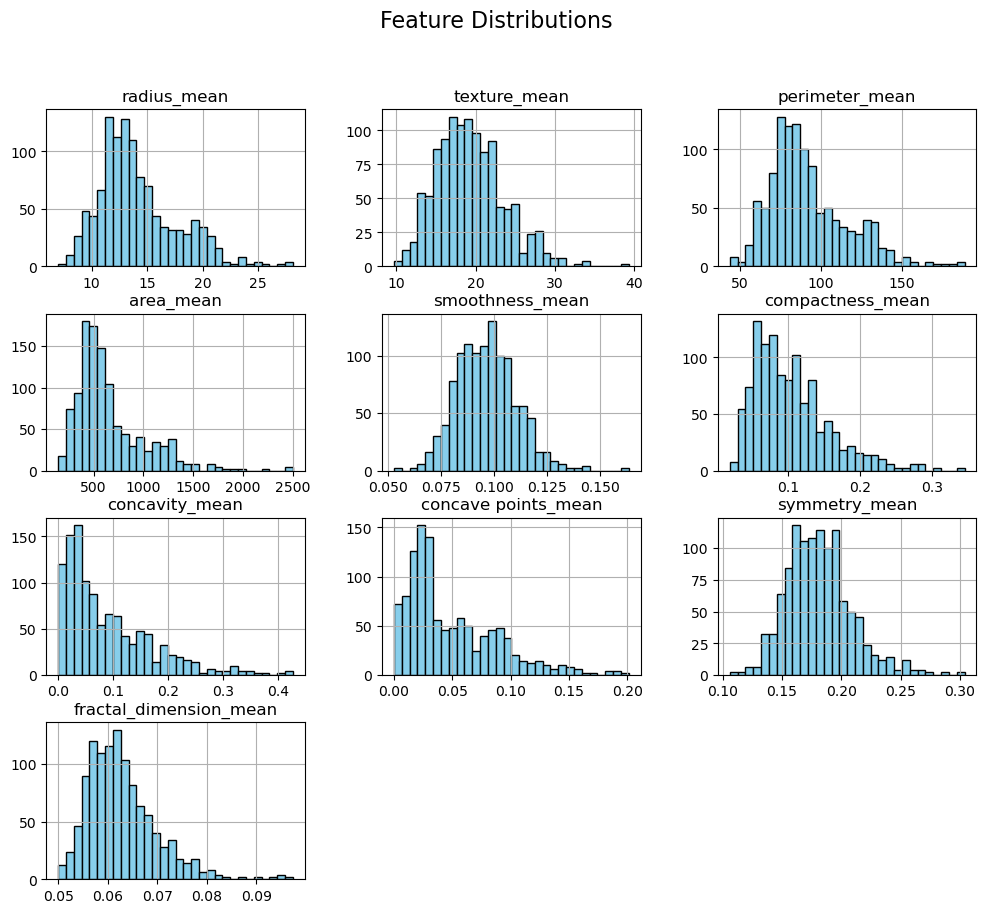

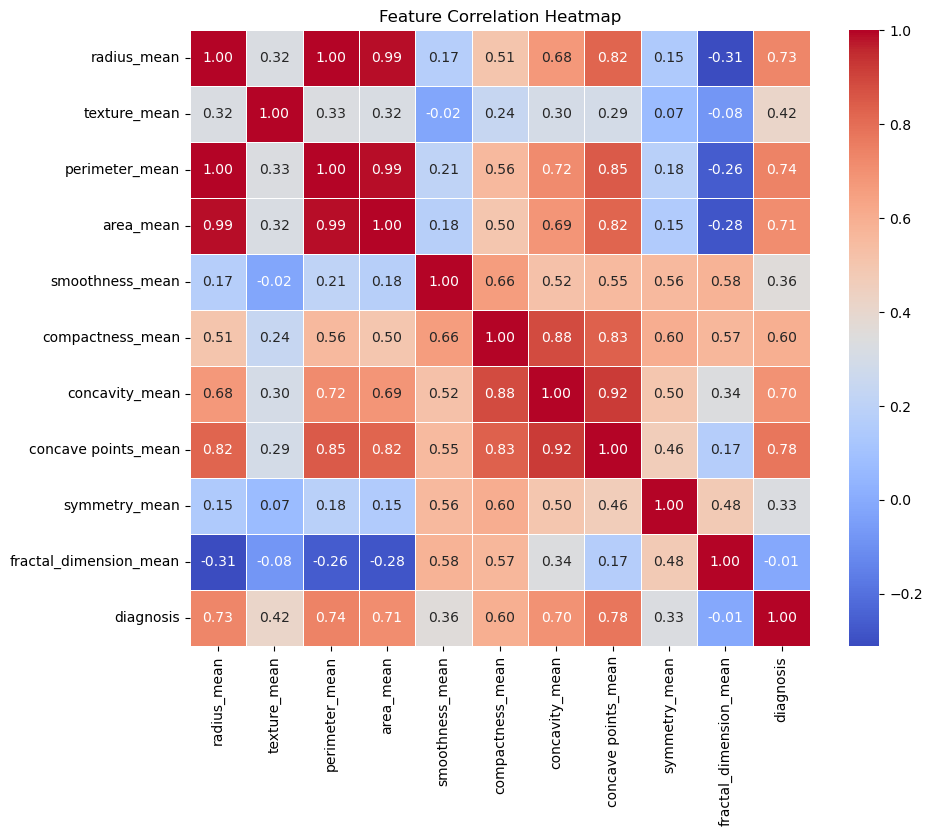

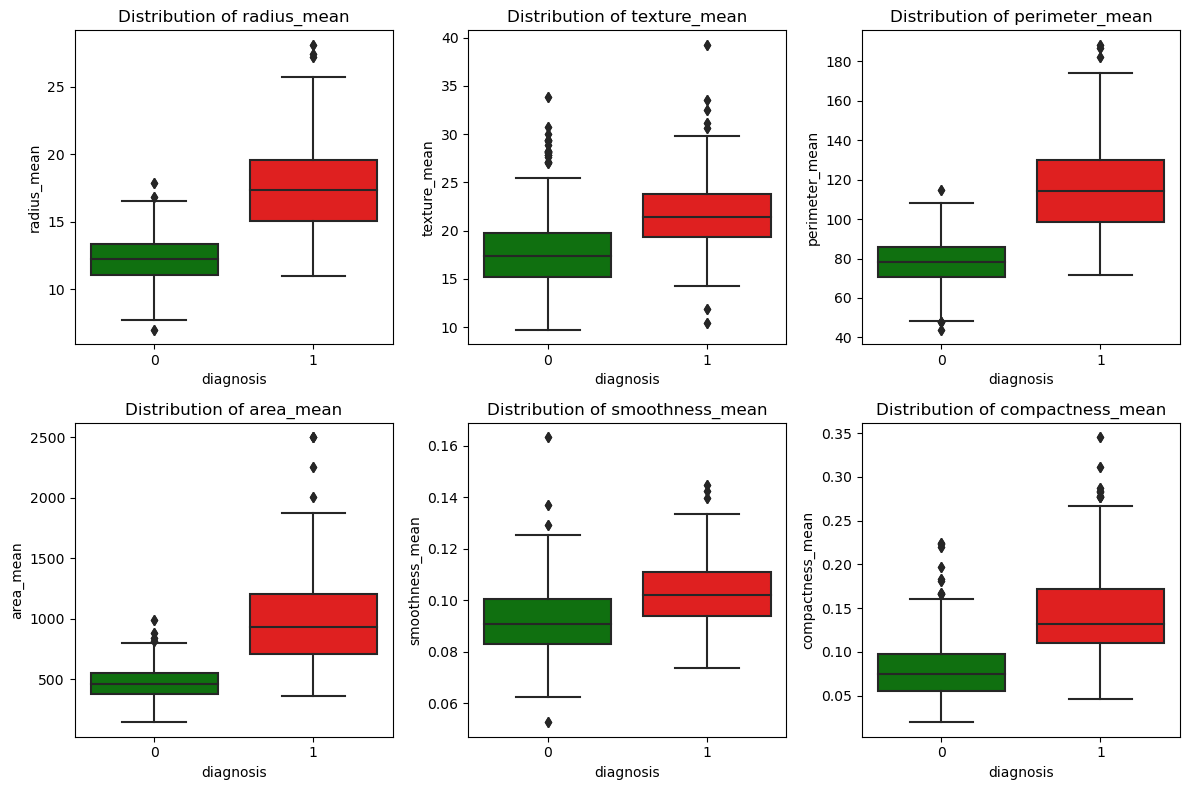

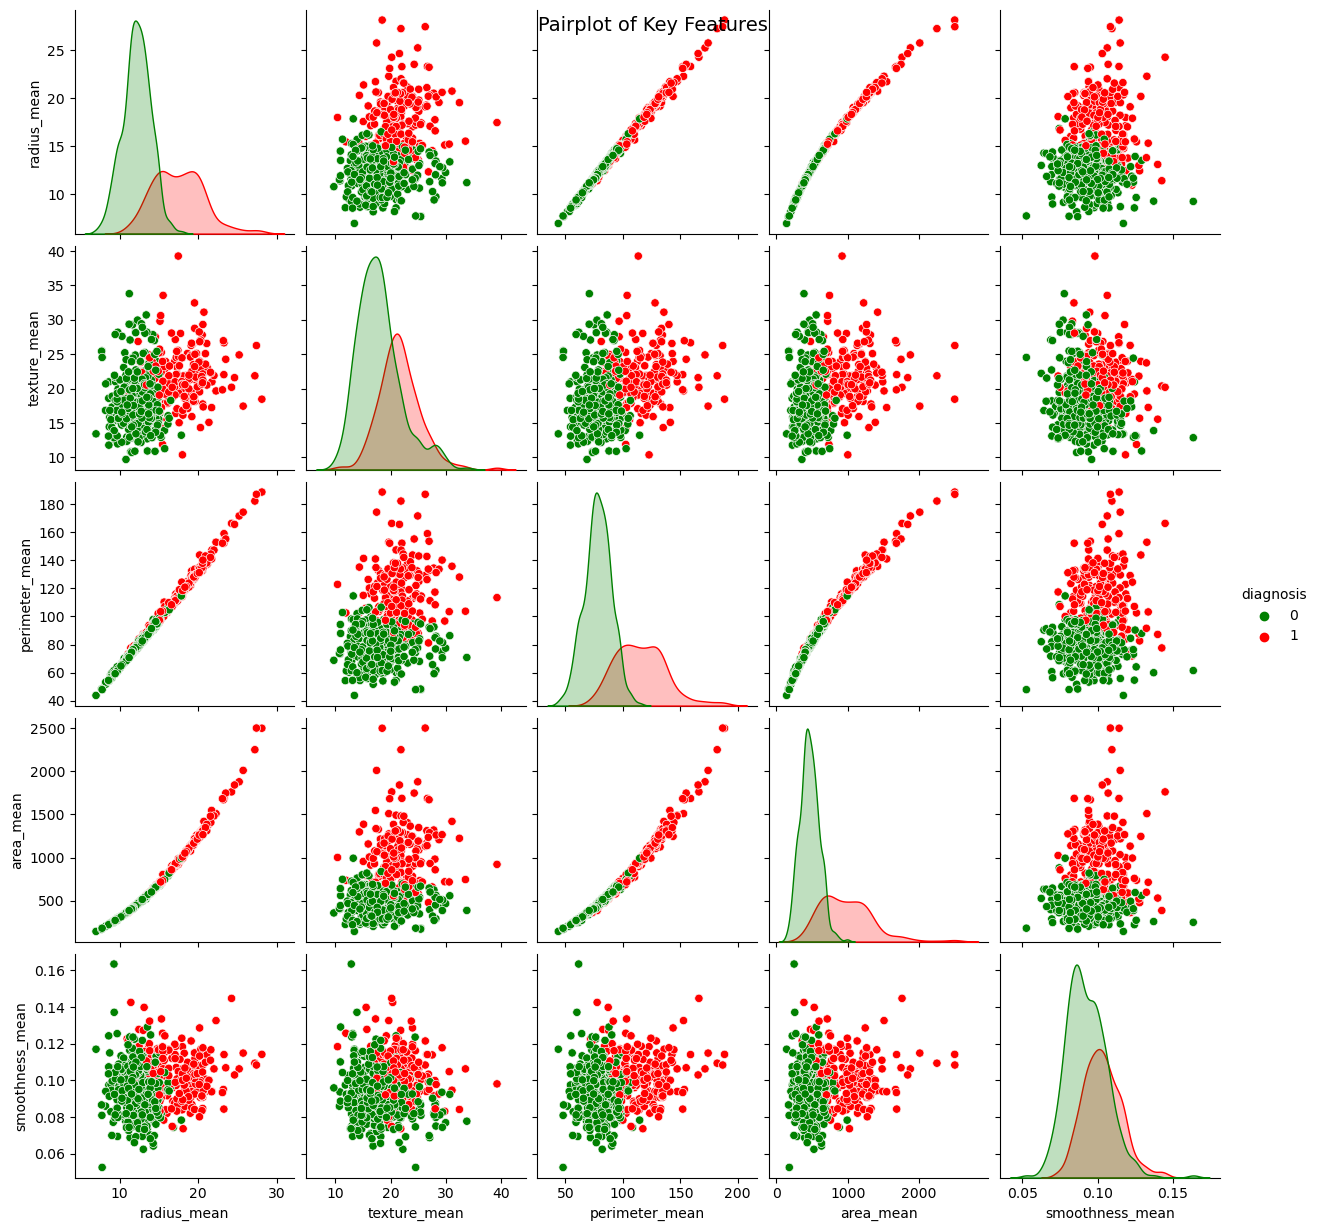

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
cp_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\CP_Data.csv")
wisconsin_data = pd.read_csv(r"C:\Users\SRITESH BISI\Downloads\pro_data\wisconsin.csv")

# Select common features
common_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave points_mean",
    "symmetry_mean", "fractal_dimension_mean"
]

cp_data = cp_data[common_features + ["diagnosis"]]
wisconsin_data = wisconsin_data[common_features + ["diagnosis"]]
merged_data = pd.concat([cp_data, wisconsin_data], ignore_index=True)

# Encode diagnosis (M = 1, B = 0)
merged_data["diagnosis"] = merged_data["diagnosis"].map({"M": 1, "B": 0})
merged_data.dropna(inplace=True)

### Class Distribution (Malignant vs Benign) ###
plt.figure(figsize=(6, 4))
sns.countplot(x=merged_data["diagnosis"], palette=["green", "red"])
plt.xticks(ticks=[0, 1], labels=["Benign", "Malignant"])
plt.title("Class Distribution of Breast Cancer")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

### Histograms of Features ###
merged_data[common_features].hist(figsize=(12, 10), bins=30, color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

### 3Correlation Heatmap ###
plt.figure(figsize=(10, 8))
corr_matrix = merged_data[common_features + ["diagnosis"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Box Plots for Feature Comparison ###
plt.figure(figsize=(12, 8))
for i, feature in enumerate(common_features[:6]):  # Select first 6 for readability
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x="diagnosis", y=feature, data=merged_data, palette=["green", "red"])
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

### Pairplot of Key Features ###
sns.pairplot(merged_data, hue="diagnosis", vars=common_features[:5], palette=["green", "red"])
plt.suptitle("Pairplot of Key Features", fontsize=14)
plt.show()